In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 156 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.8 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595738 sha256=922dfe5bb4c2d157a0ab6a79bbb7c3847afa702c2c8be24e205c2a879fd1e99a
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-zoeqd0cv
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-zoeqd0cv
     |████████████████████████████████| 132 kB 5.1 MB/s 
     |████████████████████████████████| 4.5 MB 39.5 MB/s 
     |████████████████████████████████| 4.4 MB 52.8 MB/s 
     |████████████████████████████████| 596 kB 51.4 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.0 MB/s 
     |████████████████████████████████| 8.9 MB 38.1 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |████████████████████████████████| 127 kB 60.8 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=fbd3ff2a1bdc02c14058787afa7ecbdd7a7e5981cb586c8cf7f4454a672146de
  Stored in directory

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import pandas as pd
# 데이터프레임으로 변환
# 본인 경로에 맞게 수정
chatbot_data_short = pd.read_excel('/content/drive/MyDrive/감성분석_boaz/한국어_단발성_대화_데이터셋.xlsx')
chatbot_data_conti = pd.read_excel('/content/drive/MyDrive/감성분석_boaz/한국어_연속적_대화_데이터셋.xlsx', header=1)

## 데이터 전처리


### 단발성 데이터

In [ ]:
chatbot_data_short = chatbot_data_short.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "공포", 5468], axis = 1)

mask = chatbot_data_short['Emotion'].isin(['공포', '놀람',  '혐오'])
chatbot_data_short = chatbot_data_short[~mask]

In [ ]:
chatbot_data_short.loc[(chatbot_data_short['Emotion'] == "분노"), 'Emotion'] = 0  
chatbot_data_short.loc[(chatbot_data_short['Emotion'] == "슬픔"), 'Emotion'] = 1  
chatbot_data_short.loc[(chatbot_data_short['Emotion'] == "중립"), 'Emotion'] = 2  
chatbot_data_short.loc[(chatbot_data_short['Emotion'] == "행복"), 'Emotion'] = 3  


In [ ]:
chatbot_data_short['Emotion'].value_counts()

3    6037
0    5665
1    5267
2    4830
Name: Emotion, dtype: int64

### 연속적 데이터

In [ ]:
chatbot_data_conti = chatbot_data_conti.iloc[:, 1:3]
chatbot_data_conti.columns = ['Sentence', 'Emotion']

In [ ]:
mask = chatbot_data_conti['Emotion'].isin(['중립', '분노', '슬픔', '행복'])
chatbot_data_conti = chatbot_data_conti[mask]

In [ ]:
chatbot_data_conti.loc[(chatbot_data_conti['Emotion'] == "분노"), 'Emotion'] = 0  
chatbot_data_conti.loc[(chatbot_data_conti['Emotion'] == "슬픔"), 'Emotion'] = 1  
chatbot_data_conti.loc[(chatbot_data_conti['Emotion'] == "중립"), 'Emotion'] = 2  
chatbot_data_conti.loc[(chatbot_data_conti['Emotion'] == "행복"), 'Emotion'] = 3 

In [ ]:
chatbot_data_conti['Emotion'].value_counts()

2    43786
0     3628
1     1972
3     1030
Name: Emotion, dtype: int64

### 데이터 결합

In [ ]:
import random
random.seed(1)
samples_2 = random.sample(range(43786), 2300)
samples_0 = random.sample(range(3628), 1500)

In [ ]:
chatbot_data_conti_2 = chatbot_data_conti[chatbot_data_conti['Emotion'] == 2].reset_index().drop('index', axis=1).iloc[list(samples_2),:]
chatbot_data_conti_0 = chatbot_data_conti[chatbot_data_conti['Emotion'] == 0].reset_index().drop('index', axis=1).iloc[list(samples_0),:]
chatbot_data_conti_02 = pd.concat([chatbot_data_conti_2, chatbot_data_conti_0])
chatbot_data_conti = pd.concat([chatbot_data_conti.loc[(chatbot_data_conti['Emotion'] == 1)|(chatbot_data_conti['Emotion'] == 3),:], chatbot_data_conti_02], axis = 0)
chatbot_data = pd.concat([chatbot_data_conti, chatbot_data_short])

In [ ]:
chatbot_data['Emotion'].value_counts()

1    7239
0    7165
2    7130
3    7067
Name: Emotion, dtype: int64

In [ ]:
chatbot_data

,Sentence,Emotion
23,잘됐네. 그럼 이번에 해보면 되잖아.,3
132,"이상해. 저렇게 집들이 많은데, 저 중에 내 집이 하나 없다는 게.",1
134,서울은 정말 복잡하구나. 사람도 너무 많고...,1
142,... 어... 미안...,1
171,뉴욕이요. 가서 저는 공부하고. 오빠는 취업하기로. 운이 좋았어요.,3
...,...,...
33160,유느님 내일 이면 해피투게더가하네요~^^,3
33161,승관아~ 너에게 편지를 안 쓸 수가 없네.,3
33162,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,3
33163,유재석 오라버니 해피투게더 해피파출소 편 봤어요,3


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

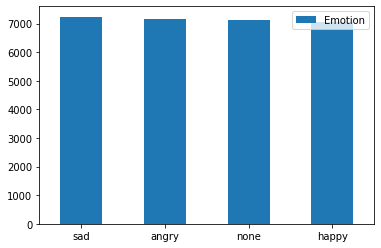

In [ ]:
dd=pd.DataFrame(chatbot_data['Emotion'].value_counts())
dd.index=['sad','angry','none','happy']
import matplotlib.pyplot as plt

dd.plot(kind='bar')
plt.xticks(rotation=0)

In [ ]:
data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [ ]:
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])

['잘됐네. 그럼 이번에 해보면 되잖아.', '3']
['됐어!! 이제 거기랑은 말도 섞지 마!! 법률 자문. 협력 업체!! 이제. 다 취소야!! ', '0']
['현역 좃부심들아 그만좀해라 월남전 갔다온것도 아닌것들이 좃부심부리고 자빠졌네', '0']
['한국에서 찍는 이유가 제작비 지원 해준다던데', '2']


### train, test split

In [ ]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0)

In [ ]:
print(len(dataset_train))
print(len(dataset_test))

21450
7151


In [ ]:
pd.DataFrame(dataset_train)[1].value_counts()

1    5416
0    5398
2    5373
3    5263
Name: 1, dtype: int64

In [ ]:
pd.DataFrame(dataset_test)[1].value_counts()

1    1823
3    1804
0    1767
2    1757
Name: 1, dtype: int64

## 모델링

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
data_train[0]

(array([   2, 2639, 7836, 5611, 6999,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(6, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 1)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=4,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("분노가")
            elif np.argmax(logits) == 1:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 2:
                test_eval.append("중립이")
            elif np.argmax(logits) == 3:
                test_eval.append("행복이")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [ ]:
#질문 무한반복하기!
sentence = 1
while sentence != 'End' :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 'End' :
        break
    predict(sentence)
    print("\n")